# 2 - Audi used car listings

---

Author: Matěj Frič (FRI0089)

Date: 21/12/2022

---

## Data description:

Dataset contains information of price, transmission, mileage, fuel type, road tax, miles per gallon (mpg), and engine size

- model audi model
- year registraion year
- price price in Euros
- transmission type of gear box
- mileage distance used
- fuelType engine fuel
- tax road tax
- mpg miles per galoon
- engineSize size in litres

## Source

[Kaggle.com](https://www.kaggle.com/datasets/mysarahmadbhat/audi-used-car-listings)

---

# EDA

In [1]:
import pandas as pd # dataframes
import numpy as np # matrices and linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # another matplotlib interface - styled and easier to use
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram
from pandasql import sqldf


sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('audi.csv', sep=',')
with pd.option_context('display.max_columns', None):
    display(df.head())

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [4]:
df.isna().sum().sort_values(ascending=False).head(5) 

model           0
year            0
price           0
transmission    0
mileage         0
dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,10668.0,2017.100675,2.167494,1997.0,2016.00,2017.0,2019.0,2020.0
price,10668.0,22896.685039,11714.841888,1490.0,15130.75,20200.0,27990.0,145000.0
mileage,10668.0,24827.244001,23505.257205,1.0,5968.75,19000.0,36464.5,323000.0
tax,10668.0,126.011436,67.170294,0.0,125.00,145.0,145.0,580.0
mpg,10668.0,50.770022,12.949782,18.9,40.90,49.6,58.9,188.3
engineSize,10668.0,1.930709,0.602957,0.0,1.50,2.0,2.0,6.3


In [6]:
df[df['tax'] == 0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
30,A1,2015,9500,Automatic,54754,Diesel,0,76.3,1.6
50,A4,2016,12750,Manual,52561,Diesel,0,74.3,2.0
58,A3,2016,10200,Manual,66369,Diesel,0,83.1,1.6
60,A1,2013,7000,Manual,76269,Diesel,0,74.3,1.6
69,A1,2016,10800,Manual,18181,Petrol,0,67.3,1.0
...,...,...,...,...,...,...,...,...,...
10430,A1,2017,13500,Manual,4520,Petrol,0,67.3,1.0
10513,A1,2013,6999,Manual,90000,Diesel,0,74.3,1.6
10591,A1,2016,11000,Manual,42082,Petrol,0,67.3,1.0
10645,A1,2016,10999,Manual,22150,Diesel,0,76.3,1.6


- Records with *tax* = 0 may be incorrect. I don't know which country the used car list is from, nor what the tax laws are there. That's why I decided to leave it that way.

In [7]:
print(len(df[df['engineSize'] == 0]))
df[df['engineSize'] == 0].head()

57


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7505,Q5,2019,44790,Automatic,5886,Petrol,135,117.7,0.0
7506,Q3,2019,32788,Automatic,1500,Diesel,145,47.1,0.0
7516,Q3,2020,29944,Manual,1500,Petrol,145,40.9,0.0
7517,Q3,2020,33333,Automatic,1500,Diesel,145,47.1,0.0
7518,Q3,2020,29944,Automatic,1500,Petrol,145,32.5,0.0


- I assume, that records with *engineSize* 0.0 represent missing values, I'll replace those with the average *engineSize*.

In [3]:
df.loc[df['engineSize'] == 0, 'engineSize'] = np.round(df['engineSize'].mean(), 1)
engine_size_mean = np.round(df['engineSize'].mean(), 1)
print(f'Mean value of engine size: {engine_size_mean}')

Mean value of engine size: 1.9


In [5]:
categorical_cols = df.select_dtypes(exclude= np.number).columns.tolist()
categorical_cols

['model', 'transmission', 'fuelType']

In [10]:
for col in categorical_cols:
    print(f'{col}: {df[col].unique()}')

model: [' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7']
transmission: ['Manual' 'Automatic' 'Semi-Auto']
fuelType: ['Petrol' 'Diesel' 'Hybrid']


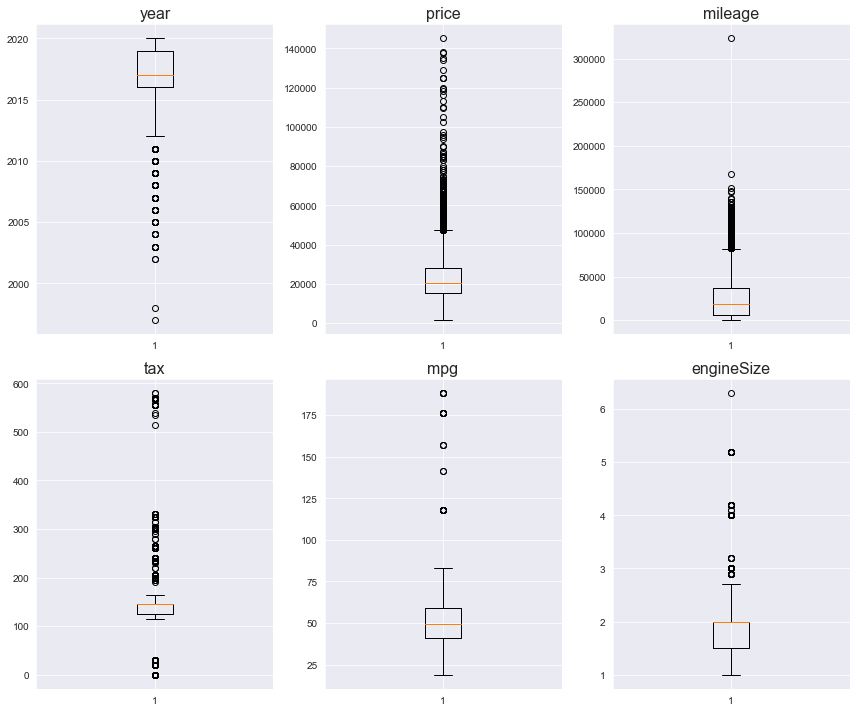

In [8]:
numeric_cols = df.select_dtypes(include= np.number).columns.tolist()

cols = 3
rows = int(len(numeric_cols) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5))

k = -1
for i, col in enumerate(numeric_cols):
    if ((i % 3) == 0):
        k += 1
    axes[k, i % 3].boxplot(df[col])
    axes[k, i % 3].set_title(col, fontsize=16)


fig.tight_layout()

- There is a considerable number of outliers int the dataset. Therefore, I'll choose robust scaler for the numeric columns.

In [12]:
df['mileage'].sort_values(ascending=False).values

array([323000, 168017, 152034, ...,      7,      5,      1])

- There is one particularly distant outlier in the *mileage* column, but it seems inappropriate to remove this record as it may be the true value (a mileage of 323,000 kilometers is quite possible). 

<AxesSubplot:>

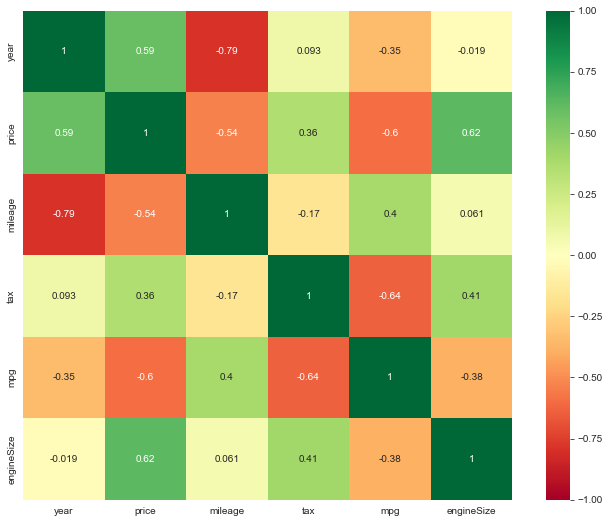

In [13]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn', vmin=-1, vmax=1, annot=True)

- The *mileage* and *year* columns are (as expected) highly negatively correlated, so one of the columns might be ommited for clustering, but since there are not that many columns, we leave them as they are.

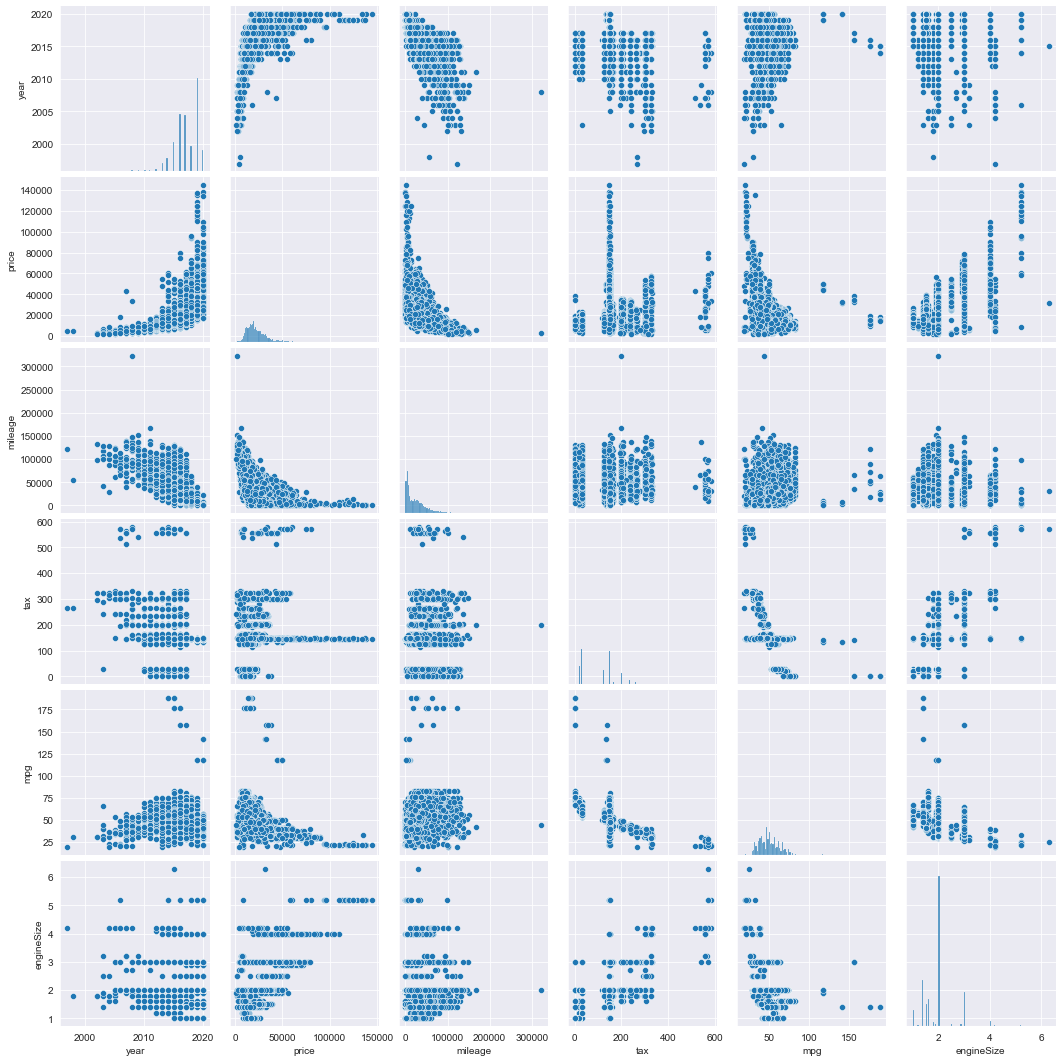

In [14]:
sns.pairplot(df[numeric_cols])

- There are a few clear relationships in the dataset, for example *mileage* and *price* or *year* and *price*.

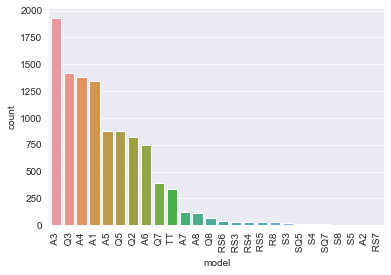

In [38]:
sns.countplot(data=df, x='model', order = df['model'].value_counts().index)
plt.xticks(rotation=90);

- We can see that the most common models are A1, A3, A4 and Q3.

## Scaling
- I'll use one-hot encoding for *fuelType* and *transmission*,
- ordinal encoding for *model* (ordered by the the count of each model) and *year* (descending by value),
- and robust scaling for the numerical columns.

In [9]:
scaler_min_max = sklearn.preprocessing.MinMaxScaler()
scaler_robust = sklearn.preprocessing.RobustScaler()
scaler_ordinal_year = sklearn.preprocessing.OrdinalEncoder(
    categories = [sorted(df['year'].astype(str).unique(), reverse=True)])   
scaler_ordinal_model = sklearn.preprocessing.OrdinalEncoder(
    categories=[df['model'].value_counts().sort_values(ascending=False).index])

# Numerical columns
df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.loc[ : , df_numeric.columns != 'year']
robust_scaled = scaler_robust.fit_transform(df_numeric.values)
df_scaled = pd.DataFrame(robust_scaled, columns=df_numeric.columns)

# Year
df_scaled['year'] = scaler_ordinal_year.fit_transform(df[['year']].astype(str))
#df_scaled['year'] = scaler_min_max.fit_transform(scaler_ordinal.fit_transform(df[['year']]))

# Transmission and fuelType
df_scaled = df_scaled.join(pd.get_dummies(df[['fuelType']]))
df_scaled = df_scaled.join(pd.get_dummies(df[['transmission']]))

# Model
df_scaled.loc[:,'model'] = scaler_ordinal_model.fit_transform(df[['model']])
#df_scaled.loc[:,'model'] = scaler_min_max.fit_transform(scaler_ordinal_model.fit_transform(df[['model']]))

# Futher scaling of numerical columns (unused)
# This scaling results in separate clusters for different fuelType/Transmission
# df_scaled[df_numeric.columns] = scaler_min_max.fit_transform(df_numeric.values) 

display(df_scaled.head(10).T)
display(df_scaled.describe().T)

,0,1,2,3,4,5,6,7,8,9
price,-0.598791,-0.287731,-0.715438,-0.264401,-0.225519,-0.489920,-0.540467,-0.657115,-0.777650,-0.637673
mileage,-0.107064,0.564111,0.358935,0.227966,-0.557520,0.434815,1.894953,1.842388,0.889042,0.113163
tax,0.250000,-6.250000,-5.750000,0.000000,0.000000,-5.750000,-5.750000,-6.250000,-6.250000,-5.750000
mpg,0.322222,0.811111,0.322222,0.983333,0.000000,0.516667,0.655556,1.166667,0.583333,0.322222
engineSize,-1.200000,0.000000,-1.200000,0.000000,-2.000000,-1.200000,0.000000,0.000000,-1.200000,-1.200000
year,3.000000,4.000000,4.000000,3.000000,1.000000,4.000000,4.000000,4.000000,5.000000,4.000000
fuelType_Diesel,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
fuelType_Hybrid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fuelType_Petrol,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
transmission_Automatic,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000


,count,mean,std,min,25%,50%,75%,max
price,10668.0,0.209708,0.911005,-1.454984,-0.394210,0.0,0.605790,9.705076
mileage,10668.0,0.191084,0.770772,-0.623005,-0.427314,0.0,0.572686,9.968602
tax,10668.0,-0.949428,3.358515,-7.250000,-1.000000,0.0,0.000000,21.750000
mpg,10668.0,0.065001,0.719432,-1.705556,-0.483333,0.0,0.516667,7.705556
engineSize,10668.0,-0.118279,1.172245,-2.000000,-1.000000,0.0,0.000000,8.600000
year,10668.0,2.898763,2.162791,0.000000,1.000000,3.0,4.000000,20.000000
fuelType_Diesel,10668.0,0.522778,0.499504,0.000000,0.000000,1.0,1.000000,1.000000
fuelType_Hybrid,10668.0,0.002625,0.051167,0.000000,0.000000,0.0,0.000000,1.000000
fuelType_Petrol,10668.0,0.474597,0.499378,0.000000,0.000000,0.0,1.000000,1.000000
transmission_Automatic,10668.0,0.253843,0.435229,0.000000,0.000000,0.0,1.000000,1.000000


# K-means Clustering

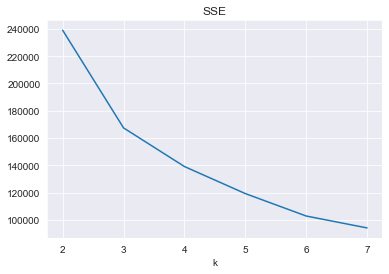

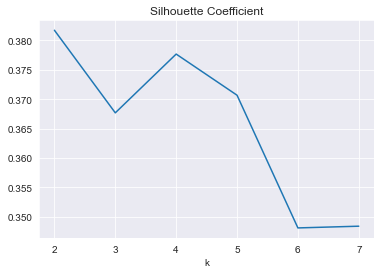

In [7]:
X = df_scaled.values
clustering_scores = []
for k in range(2, 8):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.title('SSE')
plt.figure()
df_clustering_scores.silhouette.plot()
plt.title('Silhouette Coefficient');

- I chose k=3 (based on the SSE plot, i.e., elbow method), although k=4 might also be a viable option.

In [8]:
clustering = sklearn.cluster.KMeans(n_clusters=3)
clustering.fit(X)
display(pd.Series(clustering.labels_).value_counts())

0    4843
1    3452
2    2373
dtype: int64

- The clustering is reasonably balanced.

In [9]:
df['cluster_id'] = clustering.labels_
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0           4843.0  2017.565146  2.129056  1998.0  2017.0  2018.0  2019.0   
1           3452.0  2017.491599  2.274215  1997.0  2016.0  2018.0  2019.0   
2           2373.0  2015.584071  1.177086  2005.0  2015.0  2016.0  2016.0   

                     price                                                \
               max   count          mean           std     min       25%   
cluster_id                                                                 
0           2020.0  4843.0  22042.959323   7204.659284  1490.0  17000.00   
1           2020.0  3452.0  30696.475377  14797.608301  1990.0  20403.25   
2           2017.0  2373.0  13292.689001   3213.827576  2495.0  11000.00   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
0           21490.0  26950.0   52000.0  4843.0  19415.274830  20651.875653   
1           27450.0  36990.0  145000.0  3452.0  20832.683951  22617.063431   
2           12998.0  15498.0   37999.0  2373.0  41683.286136  22416.386057   

                                                            tax              \
               min      25%      50%      75%       max   count        mean   
cluster_id                                                                    
0              5.0   4750.0  12084.0  28000.0  152034.0  4843.0  148.390460   
1              1.0   4835.0  11313.0  31362.0  323000.0  3452.0  166.848204   
2           1800.0  25936.0  36355.0  52544.0  132000.0  2373.0   20.933418   

                                                             mpg             \
                  std    min    25%    50%    75%    max   count       mean   
cluster_id                                                                    
0           18.820434  115.0  145.0  145.0  145.0  330.0  4843.0  48.548524   
1           57.971877   30.0  145.0  145.0  150.0  580.0  3452.0  43.578244   
2           13.487667    0.0   20.0   30.0   30.0  150.0  2373.0  65.765697   

                                                     engineSize            \
                  std   min   25%   50%   75%    max      count      mean   
cluster_id                                                                  
0            8.977623  29.4  40.9  48.7  53.3  141.3     4843.0  1.800103   
1           10.216968  18.9  36.2  42.8  49.6  156.9     3452.0  2.319583   
2           11.288595  53.3  60.1  64.2  68.9  188.3     2373.0  1.677202   

                                               
                 std  min  25%  50%  75%  max  
cluster_id                                     
0           0.383846  1.0  1.5  2.0  2.0  3.2  
1           0.743139  1.0  2.0  2.0  3.0  6.3  
2           0.349208  1.0  1.4  1.6  2.0  3.0

# Post-hoc Cluster Analysis

In [16]:
def plot_models() -> None:
    df_cluster_model = []
    [df_cluster_model.append(
        sqldf(f"SELECT cluster_id, model, COUNT(model) AS count FROM df WHERE cluster_id == {i} GROUP BY cluster_id, model"))
    for i in range(0, 3)]

    # for cluster in df_cluster_model:
    #     display(cluster)

    plt.figure(figsize=(20,5))
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

    for cluster, ax in zip(df_cluster_model, axes.flat):
        ax.set_title(f"Cluster {cluster['cluster_id'].unique()}")
        ax.tick_params(labelrotation=90)
        sns.barplot(data=cluster, x="model", y="count", order=cluster.sort_values("count", ascending=False).model, ax=ax)

    plt.show()

In [13]:
def describe_clusters() -> None:
    plt.figure(figsize=(20,15))
    w = 3 # width
    r = 3 # rows

    plt.subplot(r,w,1)
    sns.boxplot(data=df, y='year', x='cluster_id') 
    #plt.yticks(df['year'].unique())
    plt.title('Year', fontweight='bold')

    plt.subplot(r,w,2)
    sns.boxplot(data=df, y='price', x='cluster_id')
    plt.yscale('log') 
    plt.title('Price', fontweight='bold')

    plt.subplot(r,w,3)
    sns.boxplot(data=df, y='mileage', x='cluster_id')
    plt.yscale('log') 
    plt.title('Mileage', fontweight='bold')

    plt.subplot(r,w,4)
    sns.boxplot(data=df, y='engineSize', x='cluster_id')
    plt.title('Engine Size', fontweight='bold')

    plt.subplot(r,w,5)
    sns.boxplot(data=df, y='tax', x='cluster_id')
    plt.title('Tax', fontweight='bold')

    plt.subplot(r,w,6)
    sns.boxplot(data=df, y='mpg', x='cluster_id')
    plt.title('Miles Per Gallon', fontweight='bold')

    plt.subplot(r,w,7)
    sns.countplot(data=df, x='transmission', hue='cluster_id', order=df['transmission'].value_counts().index)

    plt.subplot(r,w,8)
    sns.countplot(
    data=df,
    x=df.loc[df['fuelType'] != 'Hybrid', 'fuelType'],
    hue='cluster_id',
    order=df.loc[df['fuelType'] != 'Hybrid', 'fuelType'].value_counts().index)
    
    plt.subplot(r,w,9)
    sns.countplot(
    data=df,
    x=df.loc[df['fuelType'] == 'Hybrid', 'fuelType'],
    hue='cluster_id',
    order=df.loc[df['fuelType'] == 'Hybrid', 'fuelType'].value_counts().index)

    plt.figure(figsize=(20,5))
    sns.countplot(data=df, x='year', hue='cluster_id', order=df['year'].value_counts().index)

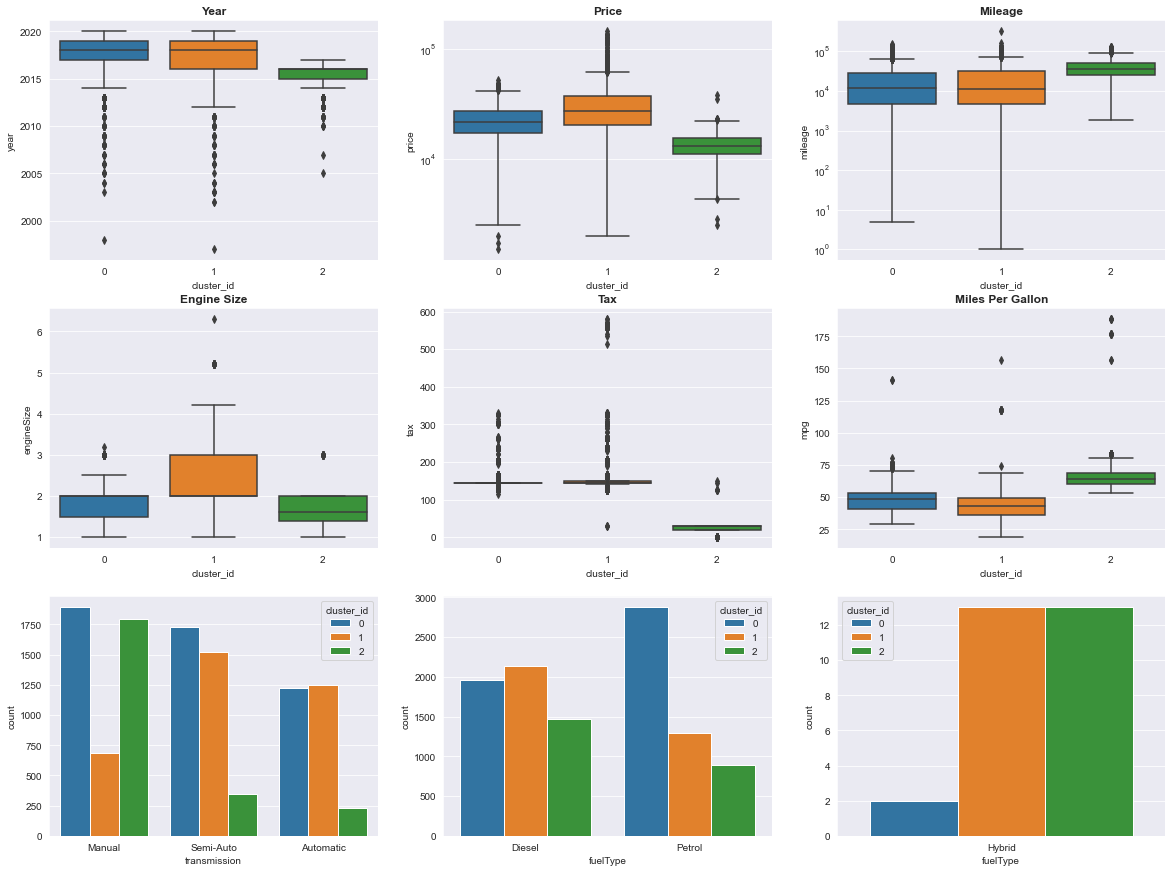

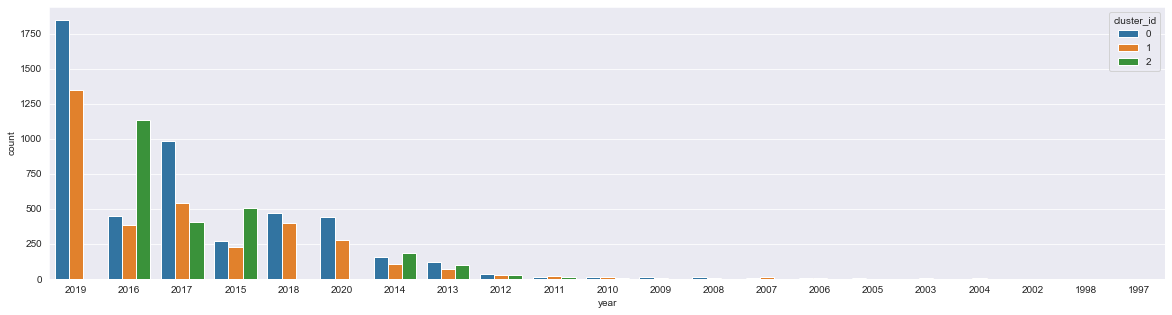

In [102]:
describe_clusters()

<Figure size 1440x360 with 0 Axes>

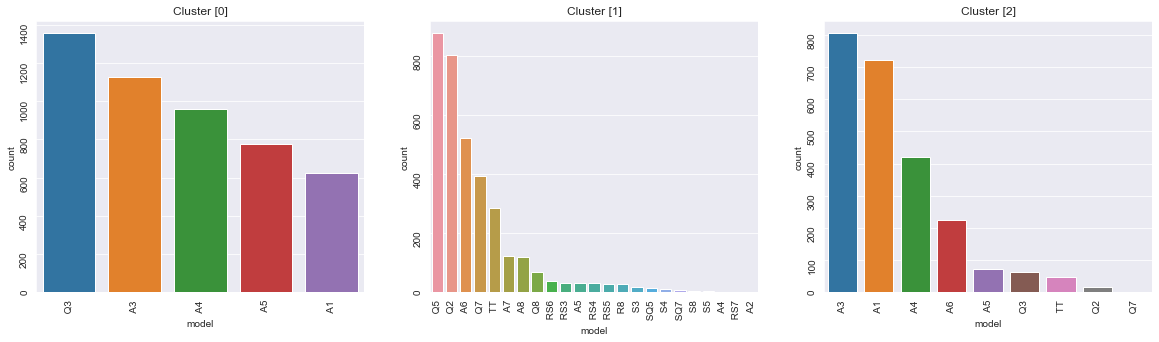

Models sorted by count: 
 A3, Q3, A4, A1, A5, Q5, Q2, A6, Q7, TT, A7, A8, Q8, RS6, RS3, RS4, RS5, R8, S3, SQ5, S4, SQ7, S8, S5, A2, RS7,

In [108]:
plot_models()
print("Models sorted by count: ")
for x in df['model'].value_counts().index:
    print(x,end=",")

Columns not mentioned did not seem to be important.

### Cluster 0

- Mostly newer cars with low to high price and mileage, including the cheapest ones
- Engine size mostly from 1.5 to 2
- Average mpg (global average is 50)
- Contains the most common models (A3, Q3, A4, A1, A5)

### Cluster 1

- Mostly newer cars with low to high price and mileage, including the most expensive ones
- Engine size mostly from 2 to 3
- Bellow average mpg
- Contains wide variety of less common models

### Cluster 2

- Mostly older cars with lower prices and higher mileage
- Engine size on the lower side mostly bellow 2
- Higher mpg (corresponding to the age of the used car)
- Contains the most common models, similar to cluster 0, but in lesser quantities (A3, Q3, A4, A1, A5, Q2, A6, Q7, TT)

# Agglomerative Clustering

In [368]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Credit to https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel('distance')

- We select 1/10 of the dataset to inspect the dendrograms for different linkage options.

In [369]:
df_sample = df_scaled.sample(n = 1_000) 

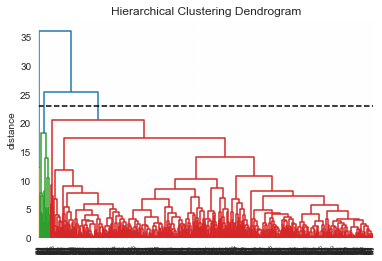

In [370]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(df_sample)
y = 23
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=y)
plt.axhline(y=y, color='black', linestyle='--');

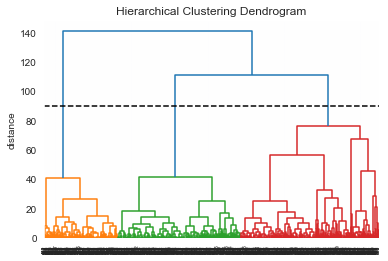

In [371]:
clustering = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(df_sample)
y = 90
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=y)
plt.axhline(y=y, color='black', linestyle='--');

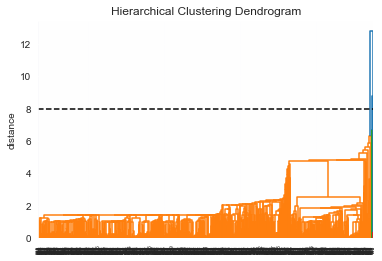

In [372]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(df_sample)
y = 8
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=y)
plt.axhline(y=y, color='black', linestyle='--');

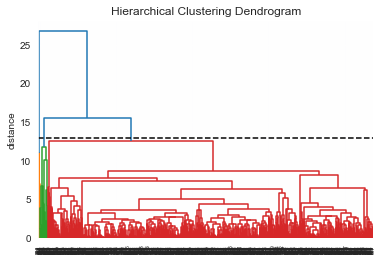

In [373]:
clustering = AgglomerativeClustering(linkage='average', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(df_sample)
y = 13
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=y)
plt.axhline(y=y, color='black', linestyle='--');

- Based on the dendrograms we choose *ward* linkage with 3 clusters.

In [110]:
clustering = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
clustering = clustering.fit(df_scaled)
pd.Series(clustering.labels_).value_counts()

0    4248
2    4053
1    2367
dtype: int64

- Once again, a fairly balanced clustering was obtained.

In [111]:
df['cluster_id']=clustering.labels_
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0           4248.0  2017.471045  2.509902  1997.0  2017.0  2018.0  2019.0   
1           2367.0  2015.605408  1.117647  2010.0  2015.0  2016.0  2016.0   
2           4053.0  2017.585739  1.830385  2011.0  2017.0  2018.0  2019.0   

                     price                                               \
               max   count          mean           std     min      25%   
cluster_id                                                                
0           2020.0  4248.0  29805.099341  14064.588203  1490.0  20499.0   
1           2017.0  2367.0  13324.884242   3190.932974  4250.0  11000.0   
2           2020.0  4053.0  21245.934616   6459.368340  5495.0  16745.0   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
0           27447.0  35490.0  145000.0  4248.0  20862.289548  23961.161478   
1           12999.0  15499.0   37999.0  2367.0  41504.675116  22181.116157   
2           20490.0  25312.0   47990.0  4053.0  19243.145078  18848.490282   

                                                            tax              \
               min      25%      50%      75%       max   count        mean   
cluster_id                                                                    
0              1.0   4550.0  10510.5  30481.0  323000.0  4248.0  164.752825   
1           1800.0  25897.5  36276.0  52401.5  130000.0  2367.0   20.570342   
2              5.0   5000.0  13312.0  28396.0  128080.0  4053.0  146.984949   

                                                             mpg             \
                  std    min    25%    50%    75%    max   count       mean   
cluster_id                                                                    
0           54.336095   30.0  145.0  145.0  150.0  580.0  4248.0  44.209463   
1           11.887221    0.0   20.0   30.0   30.0   30.0  2367.0  65.802155   
2           13.875291  115.0  145.0  145.0  150.0  265.0  4053.0  48.867283   

                                                     engineSize            \
                  std   min   25%   50%   75%    max      count      mean   
cluster_id                                                                  
0           10.374773  18.9  38.2  42.8  49.6  156.9     4248.0  2.292279   
1           11.282868  53.3  60.1  64.2  68.9  188.3     2367.0  1.678327   
2            8.577542  30.7  42.2  49.6  53.3   80.7     4053.0  1.725857   

                                               
                 std  min  25%  50%  75%  max  
cluster_id                                     
0           0.695393  1.0  2.0  2.0  3.0  6.3  
1           0.351388  1.0  1.4  1.6  2.0  3.0  
2           0.330862  1.0  1.5  2.0  2.0  3.0

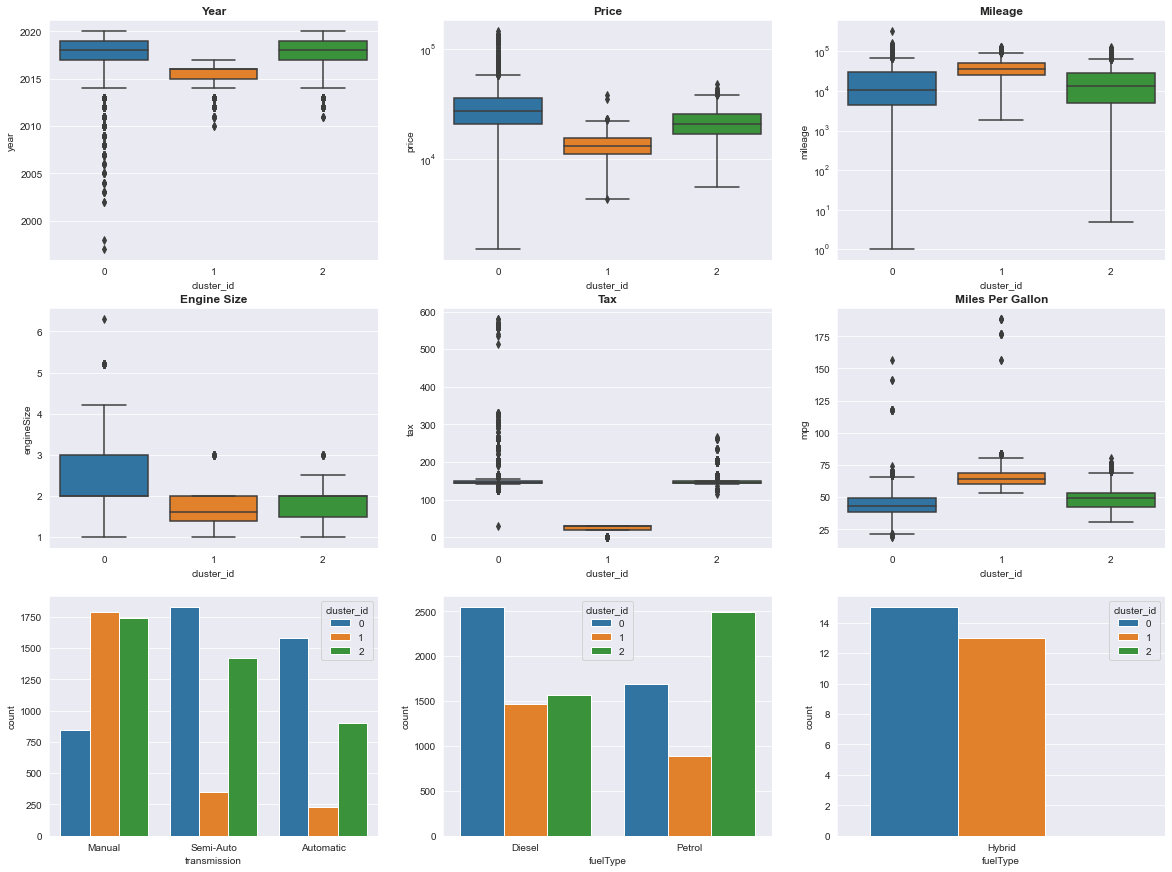

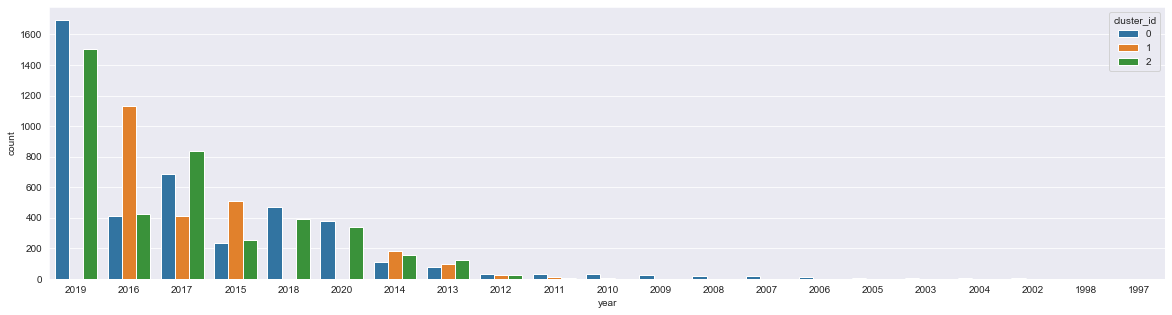

In [112]:
describe_clusters()

<Figure size 1440x360 with 0 Axes>

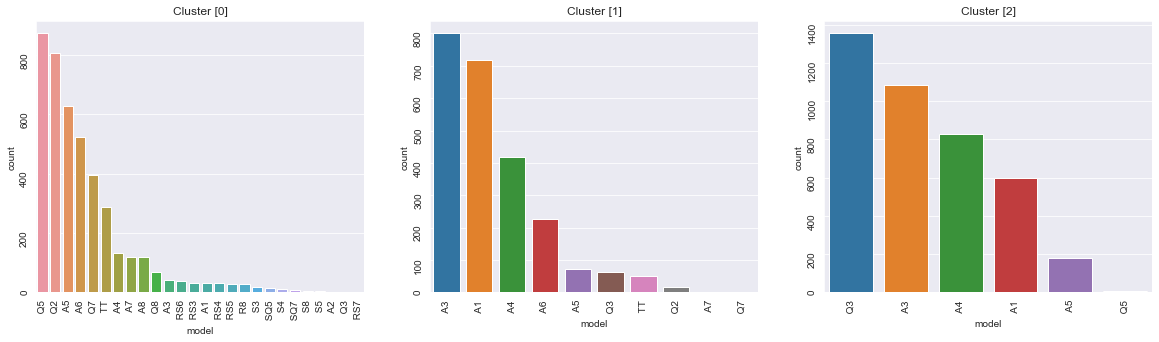

Models sorted by count: 
 A3, Q3, A4, A1, A5, Q5, Q2, A6, Q7, TT, A7, A8, Q8, RS6, RS3, RS4, RS5, R8, S3, SQ5, S4, SQ7, S8, S5, A2, RS7,

In [113]:
plot_models()
print("Models sorted by count: ")
for x in df['model'].value_counts().index:
    print(x,end=",")

Columns not mentioned did not seem to be important.

### Cluster 0

- Mostly newer cars with low to high price and mileage, including the cheapest and the most expensive ones
- Engine size mostly from 2 to 3
- Bellow average mpg (global average is 50)
- Contains wide variety of less common models

### Cluster 1

- Mostly **older** cars with lower prices and higher mileage
- Engine size on the lower side mostly bellow 2
- Higher mpg (corresponding to the age of the used car)
- Contains the most common models, similar to cluster 2, but in lesser quantities

### Cluster 2

- Mostly newer cars with prices lower than cluster 0 and higher than cluster 1
- Low to high mileage
- Engine size on the lower side mostly bellow 2
- Average mpg
- Contains the most common models (A3, Q3, A4, A1, A5)

# DBSCAN

100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


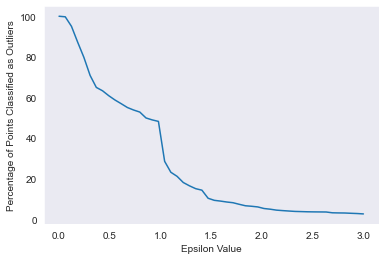

In [115]:
outlier_percent = []

for eps in tqdm(np.linspace(0.001,3,50)):
    # Credit to: https://www.kaggle.com/code/berkayalan/unsupervised-learning-clustering-complete-guide
    dbscan = DBSCAN(eps=eps,min_samples=2*df_scaled.shape[1])
    dbscan.fit(df_scaled)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    outlier_percent.append(perc_outliers)

sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")
plt.grid(False)
plt.show()

Based on the plot, let us choose eps=2.1.

In [10]:
clustering = DBSCAN(eps=2.1, min_samples = 225)
clustering = clustering.fit(df_scaled)
print(pd.Series(clustering.labels_).value_counts())

 0    6358
-1    2324
 1    1986
dtype: int64


year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
-1          2324.0  2015.330034  2.793500  1997.0  2014.0  2016.0  2017.0   
 0          6358.0  2018.183706  1.341572  2013.0  2017.0  2019.0  2019.0   
 1          1986.0  2015.705438  0.987244  2012.0  2015.0  2016.0  2016.0   

                     price                                                \
               max   count          mean           std     min       25%   
cluster_id                                                                 
-1          2020.0  2324.0  24900.519793  17776.110808  1490.0  14403.75   
 0          2020.0  6358.0  25242.636678   8653.271054  8490.0  18999.00   
 1          2017.0  1986.0  13041.462236   2895.946224  5500.0  10999.00   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
-1          19347.5  29998.5  145000.0  2324.0  41007.191480  28426.714112   
 0          23499.0  29980.0   68000.0  6358.0  14289.042152  14725.907949   
 1          12798.0  14995.0   22990.0  1986.0  39630.712991  21151.873697   

                                                              tax              \
               min       25%      50%       75%       max   count        mean   
cluster_id                                                                      
-1             1.0  21080.75  37128.5  55785.75  323000.0  2324.0  164.128657   
 0             5.0   4051.00   8145.5  20984.75  120860.0  6358.0  145.357817   
 1          1800.0  24995.50  34503.5  49548.00  130000.0  1986.0   19.471299   

                                                              mpg             \
                  std    min     25%    50%    75%    max   count       mean   
cluster_id                                                                     
-1          91.131998    0.0  143.75  150.0  200.0  580.0  2324.0  47.813769   
 0           6.169451  115.0  145.00  145.0  145.0  205.0  6358.0  47.283328   
 1          12.177215    0.0    0.00   20.0   30.0   30.0  1986.0  65.391742   

                                                     engineSize            \
                  std   min   25%   50%   75%    max      count      mean   
cluster_id                                                                  
-1          16.476383  18.9  39.2  47.1  53.3  188.3     2324.0  2.474010   
 0           9.135395  30.1  40.4  47.9  52.3   80.7     6358.0  1.844778   
 1           7.289178  53.3  58.9  65.7  70.6   83.1     1986.0  1.624572   

                                               
                 std  min  25%  50%  75%  max  
cluster_id                                     
-1          0.735435  1.0  2.0  2.0  3.0  6.3  
 0          0.444907  1.0  1.5  2.0  2.0  4.0  
 1          0.341740  1.0  1.4  1.6  2.0  3.0

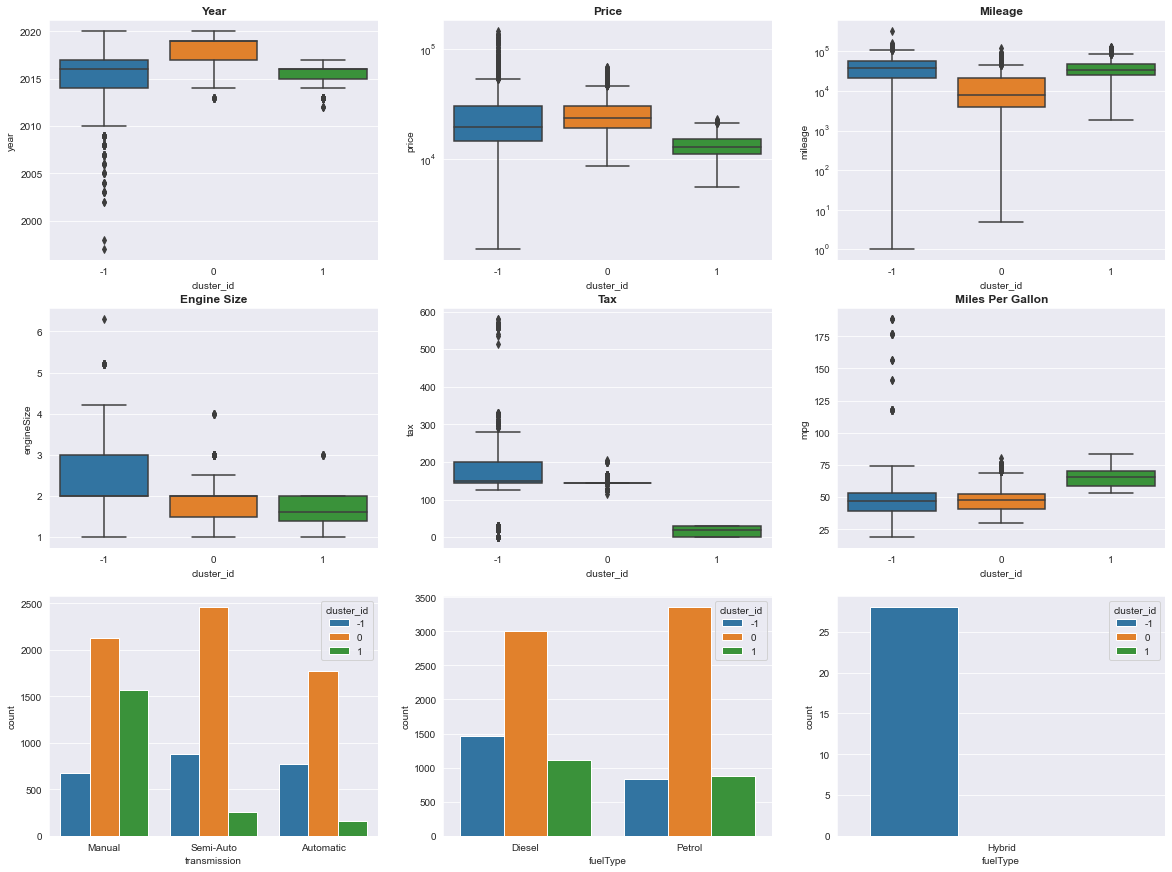

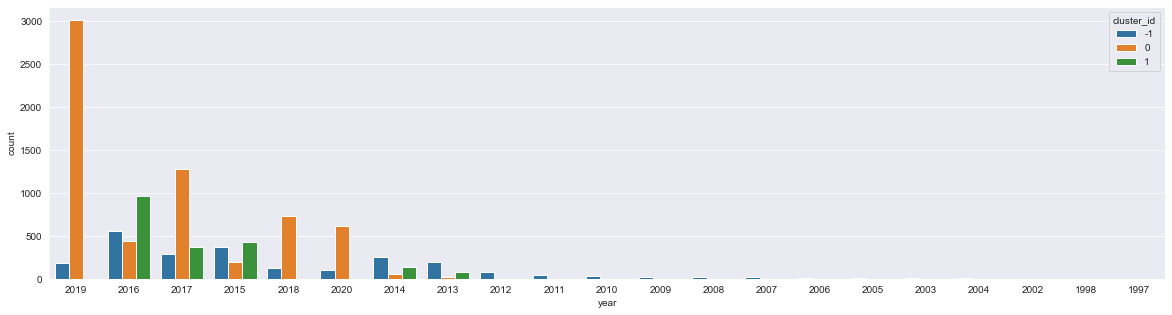

In [14]:
df['cluster_id']=clustering.labels_
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())
describe_clusters()

<Figure size 1440x360 with 0 Axes>

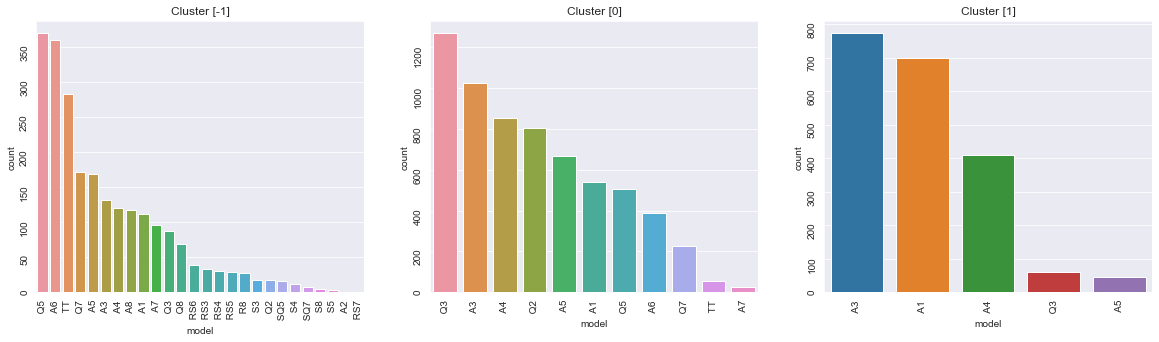

Models sorted by count: 
 A3, Q3, A4, A1, A5, Q5, Q2, A6, Q7, TT, A7, A8, Q8, RS6, RS3, RS4, RS5, R8, S3, SQ5, S4, SQ7, S8, S5, A2, RS7,

In [17]:
df_cluster_model = []
[df_cluster_model.append(
    sqldf(f"SELECT cluster_id, model, COUNT(model) AS count FROM df WHERE cluster_id == {i} GROUP BY cluster_id, model"))
for i in range(-1, 2)]

# for cluster in df_cluster_model:
#     display(cluster)

plt.figure(figsize=(20,5))
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

for cluster, ax in zip(df_cluster_model, axes.flat):
    ax.set_title(f"Cluster {cluster['cluster_id'].unique()}")
    ax.tick_params(labelrotation=90)
    sns.barplot(data=cluster, x="model", y="count", order=cluster.sort_values("count", ascending=False).model, ax=ax)

plt.show()
print("Models sorted by count: ")
for x in df['model'].value_counts().index:
    print(x,end=",")

Columns not mentioned did not seem to be important.

### Cluster -1

- Mostly older cars with low to high price and mileage, including the cheapest and the most expensive ones
- Engine size mostly from 2 to 3
- Average mpg (global average is 50)
- Higher tax
- Wide variety of models

### Cluster 0

- Mostly newer cars with corresponding prices, mileage from low to high
- Engine size on the lower side mostly bellow 2
- Average mpg 
- Mainly common models

### Cluster 1

- Mostly older cars with lower prices and higher mileage
- Engine size bellow 2 except some outliers
- Higher mpg (corresponding to the age of the used car)
- Low taxes
- The most common models

# Different scaling + K-means

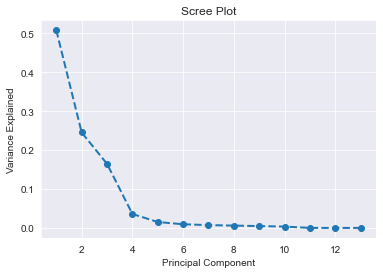

[0.51 0.25 0.16 0.04 0.02 0.01 0.01 0.01 0.   0.   0.   0.   0.  ]


0.9180472860420972

In [18]:
pca = PCA(n_components=13)
pca_fit = pca.fit_transform(df_scaled)

pc_values = np.arange(pca.n_components_) + 1
plt.plot(pc_values, pca.explained_variance_ratio_, 'o--', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_[0:3])

- According to PCA, three of the principal components explain almost 92 % of the total variation in the dataset. 
- Let's drop the *model* column as it seems to bias the results too much anyway.

In [19]:
df_scaled = df_scaled.drop(['model'], axis=1)
display(df_scaled.head(5).T)
display(df_scaled.describe().T)

,0,1,2,3,4
price,-0.598791,-0.287731,-0.715438,-0.264401,-0.225519
mileage,-0.107064,0.564111,0.358935,0.227966,-0.557520
tax,0.250000,-6.250000,-5.750000,0.000000,0.000000
mpg,0.322222,0.811111,0.322222,0.983333,0.000000
engineSize,-1.200000,0.000000,-1.200000,0.000000,-2.000000
year,3.000000,4.000000,4.000000,3.000000,1.000000
fuelType_Diesel,0.000000,1.000000,0.000000,1.000000,0.000000
fuelType_Hybrid,0.000000,0.000000,0.000000,0.000000,0.000000
fuelType_Petrol,1.000000,0.000000,1.000000,0.000000,1.000000
transmission_Automatic,0.000000,1.000000,0.000000,1.000000,0.000000


,count,mean,std,min,25%,50%,75%,max
price,10668.0,0.209708,0.911005,-1.454984,-0.394210,0.0,0.605790,9.705076
mileage,10668.0,0.191084,0.770772,-0.623005,-0.427314,0.0,0.572686,9.968602
tax,10668.0,-0.949428,3.358515,-7.250000,-1.000000,0.0,0.000000,21.750000
mpg,10668.0,0.065001,0.719432,-1.705556,-0.483333,0.0,0.516667,7.705556
engineSize,10668.0,-0.118279,1.172245,-2.000000,-1.000000,0.0,0.000000,8.600000
year,10668.0,2.898763,2.162791,0.000000,1.000000,3.0,4.000000,20.000000
fuelType_Diesel,10668.0,0.522778,0.499504,0.000000,0.000000,1.0,1.000000,1.000000
fuelType_Hybrid,10668.0,0.002625,0.051167,0.000000,0.000000,0.0,0.000000,1.000000
fuelType_Petrol,10668.0,0.474597,0.499378,0.000000,0.000000,0.0,1.000000,1.000000
transmission_Automatic,10668.0,0.253843,0.435229,0.000000,0.000000,0.0,1.000000,1.000000


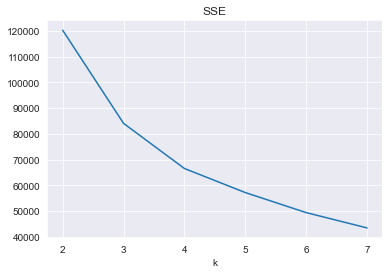

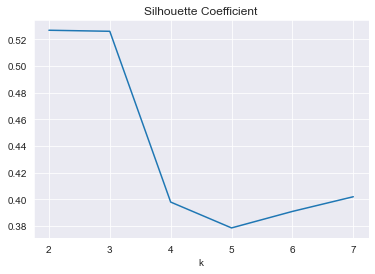

In [20]:
X = df_scaled.values
clustering_scores = []
for k in range(2, 8):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.title('SSE')
plt.figure()
df_clustering_scores.silhouette.plot()
plt.title('Silhouette Coefficient');

- Again, 3 clusters seem to be the best possible choice.

In [21]:
clustering = sklearn.cluster.KMeans(n_clusters=3)
clustering.fit(X)
display(pd.Series(clustering.labels_).value_counts())
df['cluster_id'] = clustering.labels_

1    6985
0    2368
2    1315
dtype: int64

- The clustering is not very balanced.

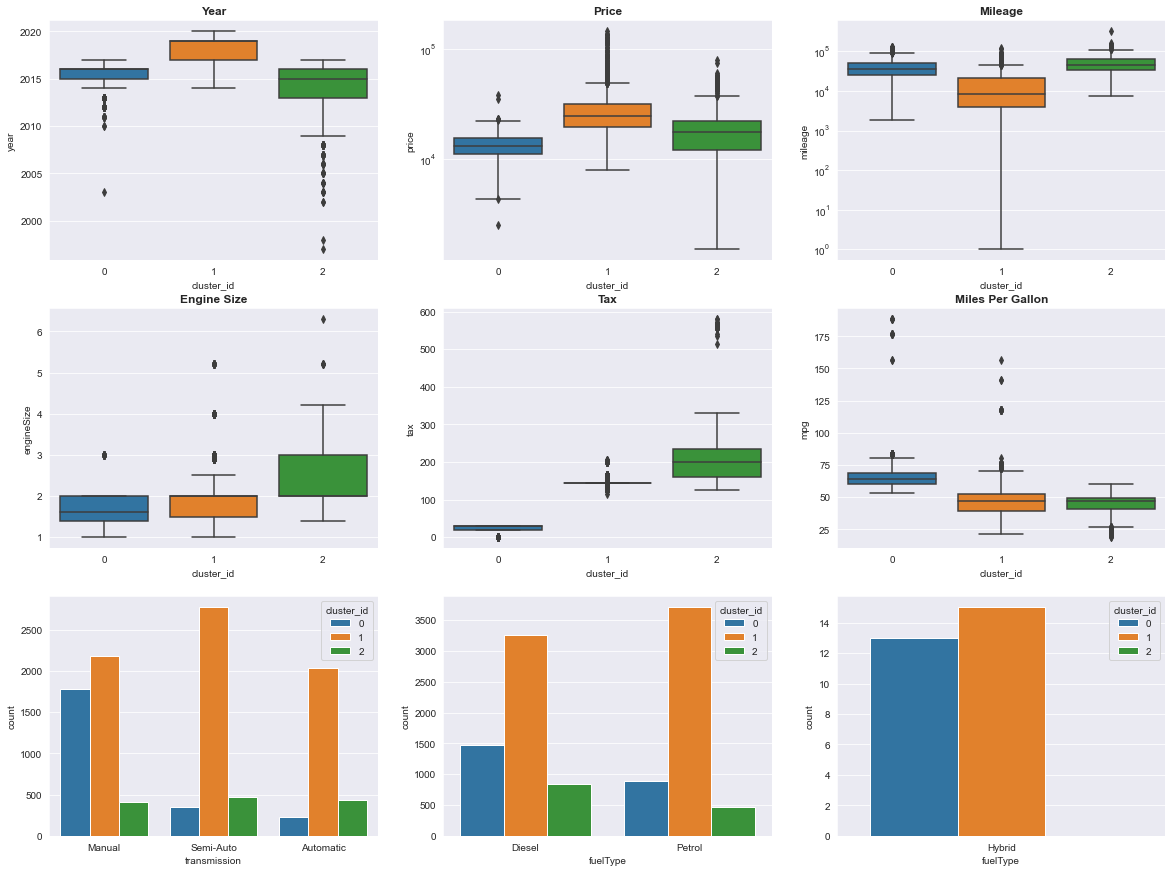

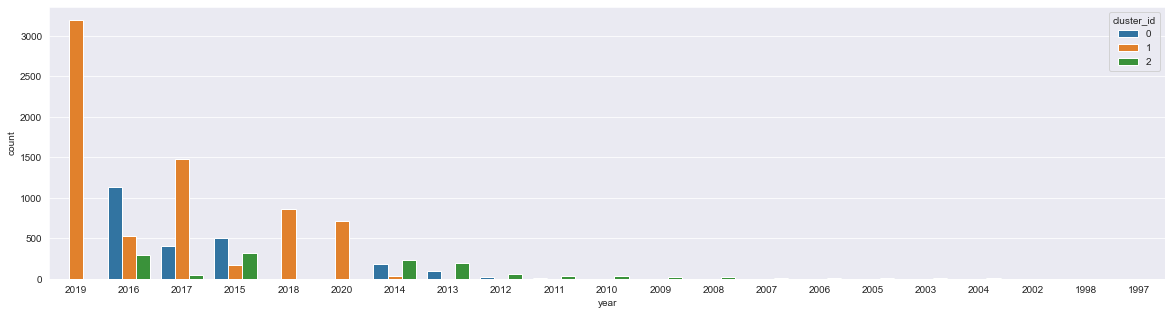

<Figure size 1440x360 with 0 Axes>

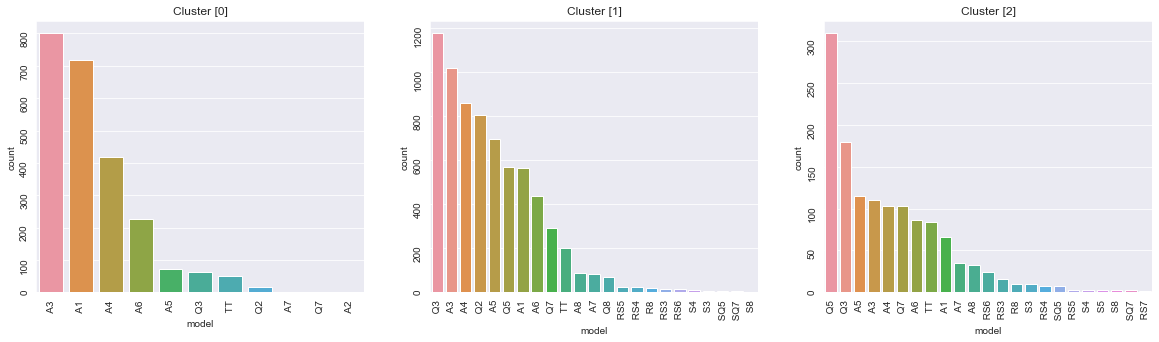

Models sorted by count: 
 A3, Q3, A4, A1, A5, Q5, Q2, A6, Q7, TT, A7, A8, Q8, RS6, RS3, RS4, RS5, R8, S3, SQ5, S4, SQ7, S8, S5, A2, RS7,

In [22]:
describe_clusters()
plot_models()
print("Models sorted by count: ")
for x in df['model'].value_counts().index:
    print(x,end=",")

Columns not mentioned did not seem to be important.

### Cluster 0

- Older cars with lower prices
- High mileage
- Engine size bellow 2 except some outliers
- Higher mpg (global average is 50)
- Mainly common models

### Cluster 1

- Mostly newer cars with higher prices, including the most expensive ones
- Cars with low to high mileage, including the lowest mileage
- Engine size mostly from 1.5 to 2
- Average mpg
- Wide variety of models

### Cluster 2

- Mostly older cars with low to high prices and higher mileage
- Engine size mostly from 2 to 3
- Average mpg
- Wide variety of models

# Summary

I perfomed 4 different clustering analyses twice K-means (with different scaling), agglomerative clustering and DBSCAN.

There are some indications of clusters, nevertheless the boundaries among the clusters are very thin. The attributes (columns) that most often differ among clusters are *price*, *year*, *mileage*, *engineSize*, *mpg* and *tax*. In all approaches to clustering, three clusters appeared to be the most satisfactory number.

A different scaling of the dataset might yield better results. 